In [1]:
import sys
from sys import platform
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.ticker import ScalarFormatter
from matplotlib.gridspec import GridSpec
import copy
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

import numpy as np
import seaborn as sns
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.integrate import quad
from IPython.display import display, Math
from scipy.interpolate import CubicSpline
from tqdm import tqdm

import pickle

from astropy.io import fits, ascii
from astropy.table import Table
from astropy.modeling import functional_models, fitting
from astropy.timeseries import LombScargle

import stingray.events as ev
import stingray.lightcurve as lc
from stingray import io
import stingray.powerspectrum as powspec 
import stingray.crossspectrum as crossspec
from stingray.pulse.search import phaseogram, plot_phaseogram, plot_profile, epoch_folding_search, z_n_search
from stingray.pulse.pulsar import fold_events, pulse_phase
import stingray.gti as sting_gti
import stingray.pulse.accelsearch as accelsearch
from stingray import stats
from stingray.deadtime import fad


sns.set_context('paper')
sns.set(font_scale=1.6)
sns.set_style("whitegrid")
sns.set_style({'axes.edgecolor': 'black', 'xtick.bottom': True, 'ytick.left': True,})
sns.set_palette("colorblind")

sys.path.insert(1, '/Users/sean/scripts/helpers')

from stingray_plus import *

root_dir = '/Users/sean/astro/Swift_J0243d6p6124/'

/Users/sean/opt/miniconda3/lib/python3.9/site-packages/stingray/utils.py:25: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")


In [2]:
OBSID='90901321002'

pipeline_dir = root_dir + OBSID + '_pipe_out/'
plot_dir = root_dir + 'figures/'

# Calculate the FAD and Z_n search

In [3]:
events = extract_events(pipeline_dir + 'nu' + OBSID + 'A01_cl_bc_regfilt_3-78keV.evt', pipeline_dir + 'nu' + OBSID + 'B01_cl_bc_regfilt_3-78keV.evt')
all_times = np.sort(np.concatenate([events[0].time, events[1].time]))
print(np.min(all_times))

425566542.7625644


In [11]:
fad_pds = fad.FAD(events[0], events[1], segment_size=1024., dt=1.0/8192., norm='frac', return_objects=True)['ptot']
pickle.dump(fad_pds, open(pipeline_dir + 'FAD_ptot_rms.txt', 'wb'))
# fad_pds = pickle.load(open(pipeline_dir + 'FAD_ptot_rms.txt', 'rb'))
# print(fad_pds.freq[:5])

13it [14:04, 65.00s/it]


In [12]:
if fad_pds.norm == 'frac':
    fad_pds.power_err = fad_pds.power/np.sqrt(fad_pds.m)
elif fad_pds.norm == 'leahy':
    fad_pds.power_err = fad_pds.power/np.sqrt(fad_pds.m/2.)
# pickle.dump(fad_pds, open(pipeline_dir + 'FAD_ptot_Leahy.txt', 'wb'))
# print(fad_pds.df/2)
# print(fad_pds.freq)
log_pds = fad_pds.rebin_log(f=0.005)
if fad_pds.norm =='leahy':
    p_noise = 2.0
else:
    p_noise = np.mean(fad_pds.power[fad_pds.freq>10.])
print(p_noise)

0.006519558232539985


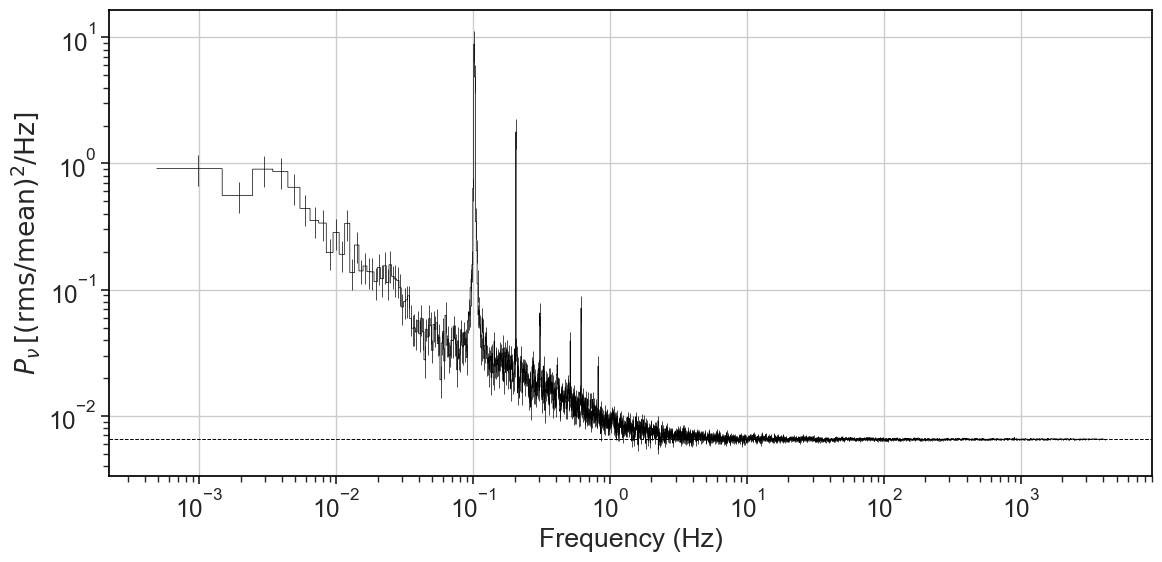

In [13]:
plt.figure(figsize=(12,6))
plt.errorbar(log_pds.freq, log_pds.power, yerr=log_pds.power_err, \
                     fmt='none', color='black', lw=0.5, rasterized=False)
plt.step(np.concatenate([[log_pds.freq[0]-log_pds.df/2.], log_pds.freq]), np.concatenate([[log_pds.power[0]], log_pds.power]), where='mid', color='black', lw=0.5, rasterized=False)

plt.axhline(p_noise, color='black', ls='--', lw=0.7)
    
plt.loglog()
plt.xlabel('Frequency (Hz)')

if fad_pds.norm =='leahy':
    plt.ylabel('Leahy Power')
else:
    plt.ylabel(r'$P_{\nu}\,[\mathrm{(rms/mean)^{2}/Hz}]$')
plt.tight_layout()
plt.savefig(plot_dir + OBSID + '_FAD_ptot_rms.pdf')